# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
X = titanic.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
# Explore the data

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Ticket    891 non-null    object 
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 62.8+ KB


In [6]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Count'>

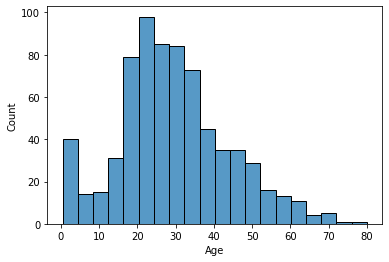

In [9]:
sns.histplot(X['Age'])

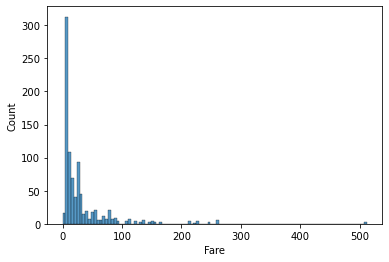

In [11]:
sns.histplot(X['Fare']);

## Using `Pipeline` and `FunctionTransformer`

Let's try a very simple pipeline first.

In [12]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

In [13]:
# The FunctionTransformer will turn my function
# into a transformer.

GrabNumeric = FunctionTransformer(grab_numeric)

In [14]:
type(GrabNumeric)

sklearn.preprocessing._function_transformer.FunctionTransformer

In [15]:
pipe = Pipeline(steps=[('num', GrabNumeric),
                       ('ss', StandardScaler())])

In [16]:
pipe.fit(X_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x7f9a4975eaf0>)),
                ('ss', StandardScaler())])

In [17]:
pipe.transform(X_train)

array([[-1.62051704,         nan, -0.46765956, -0.46887833, -0.0325683 ],
       [ 0.80934914, -0.30465857, -0.46765956, -0.46887833, -0.48733085],
       [-0.40558395, -0.3735649 , -0.46765956,  2.04687047, -0.34285405],
       ...,
       [ 0.80934914,  0.79784282,  1.22097065, -0.46887833, -0.35045024],
       [-1.62051704, -1.06262827,  0.37665554,  2.04687047,  1.7030926 ],
       [-1.62051704, -0.58028391, -0.46765956,  0.78899607,  0.8747751 ]])

That looks like it worked!

## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [18]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
X.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [47]:
list(X.columns[(X.dtypes.values == int) | (X.dtypes.values == float)])

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [20]:
# We'll throw these mini-pipelines into our ColumnTransformer.

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [30]:
# Columns to feed to column transformer
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [31]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.

CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, num_cols),
                                         ('subpipe_cat', subpipe_cat, cat_cols)],
                           remainder='passthrough')

In [40]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

logreg_model_pipe = Pipeline(steps=[('ct', CT),
                            ('logreg', LogisticRegression(random_state=42))])

In [41]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                           

In [42]:
logreg_model_pipe.score(X_train, y_train)

0.8922155688622755

## Bringing in Our Modeling Class from before

In [48]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [49]:
log_pipe = ModelWithCV(logreg_model_pipe, model_name='log_pipe', X=X_train, y=y_train)

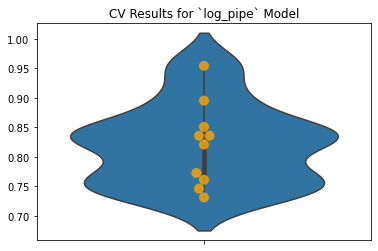

In [50]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax);

In [52]:
log_pipe.print_cv_summary()

CV Results for `log_pipe` model:
            0.82049 ± 0.06651 accuracy
        


## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Random Forest

In [84]:
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

In [85]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                           

In [86]:
rfc_model_pipe.score(X_train, y_train)

0.9985029940119761

In [87]:
forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)

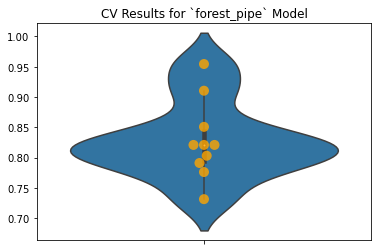

In [88]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

In [89]:
forest_pipe.print_cv_summary()

CV Results for `forest_pipe` model:
            0.82800 ± 0.06124 accuracy
        


### Gradient Booster

In [90]:
gbc_model_pipe = Pipeline([('ct', CT), ('gbc', GradientBoostingClassifier(random_state=42))])

In [91]:
gbc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                           

In [92]:
gbc_model_pipe.score(X_train, y_train)

0.8622754491017964

In [93]:
boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train,
                         y=y_train)

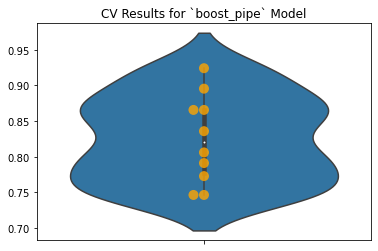

In [94]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax);

In [95]:
boost_pipe.print_cv_summary()

CV Results for `boost_pipe` model:
            0.82492 ± 0.05907 accuracy
        


## Tuning and Cross-Validating

In [101]:
rfc_model_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                           

In [108]:
rfc_model_pipe.named_steps['ct'].named_transformers_['subpipe_cat'].named_steps

{'cat_impute': SimpleImputer(strategy='most_frequent'),
 'ohe': OneHotEncoder(handle_unknown='ignore', sparse=False)}

# If we wanted to grid search the cat imputer
'ct__cat_subpipe_cat__cat_impute__strategy': [value1, value2]

In [121]:
params = {}
params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__min_samples_leaf'] = [1, 5, 10]
params['rfc__max_depth'] = [5, 10, 15]
params

{'rfc__criterion': ['gini', 'entropy'],
 'rfc__min_samples_leaf': [1, 5, 10],
 'rfc__max_depth': [5, 10, 15]}

In [124]:
gs = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid=params,
                 cv=10, verbose=3, n_jobs=-3)

In [125]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-3)]: Done 116 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-3)]: Done 180 out of 180 | elapsed:   10.4s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
             

In [126]:
gs.best_params_

{'rfc__criterion': 'entropy', 'rfc__max_depth': 15, 'rfc__min_samples_leaf': 1}

In [127]:
params = {}
params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__min_samples_leaf'] = [1, 5, 10]
params['rfc__max_depth'] = [15, 20, 25]
params

{'rfc__criterion': ['gini', 'entropy'],
 'rfc__min_samples_leaf': [1, 5, 10],
 'rfc__max_depth': [15, 20, 25]}

In [130]:
gs2 = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid=params,
                 cv=10, verbose=3, n_jobs=-3)

In [131]:
gs2.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-3)]: Done 116 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-3)]: Done 180 out of 180 | elapsed:    8.3s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
             

In [132]:
best_model = gs2.best_estimator_

In [133]:
best_model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                           

In [134]:
gs2.best_params_

{'rfc__criterion': 'entropy', 'rfc__max_depth': 25, 'rfc__min_samples_leaf': 1}

In [114]:
gs.best_score_

0.8279963817277249

In [115]:
# Mean test score for each of six models

gs.cv_results_['mean_test_score']

array([0.82799638, 0.6272275 , 0.62424242, 0.81906377, 0.6272275 ,
       0.62424242])

In [117]:
results = gs.cv_results_

In [118]:
type(results)

dict

In [119]:
results

{'mean_fit_time': array([0.23477132, 0.11735234, 0.1200398 , 0.21883647, 0.13798065,
        0.13845632]),
 'std_fit_time': array([0.04047264, 0.02430737, 0.02125947, 0.02384585, 0.02183567,
        0.02543987]),
 'mean_score_time': array([0.01304209, 0.01049833, 0.01184905, 0.01051733, 0.01131237,
        0.01098595]),
 'std_score_time': array([0.00496943, 0.00215944, 0.00422841, 0.0013479 , 0.00197103,
        0.00204667]),
 'param_rfc__criterion': masked_array(data=['gini', 'gini', 'gini', 'entropy', 'entropy',
                    'entropy'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_rfc__min_samples_leaf': masked_array(data=[1, 5, 10, 1, 5, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 1},
  {'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 5},
  {'rfc__criterion':

## `imblearn` Pipelines

### Dealing with the Target Imbalance

Let's use `SMOTE()`:

In [137]:
y_train.value_counts(normalize=True)

0    0.621257
1    0.378743
Name: Survived, dtype: float64

In [138]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [139]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

In [140]:
X_train_clean = X_train.select_dtypes(['float', 'int']).dropna()
y_train_clean = y_train[X_train_clean.index]

In [141]:
y_train_clean.value_counts()

0    317
1    219
Name: Survived, dtype: int64

In [142]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

1    317
0    317
Name: Survived, dtype: int64

In [145]:
# Distribution where count of 1's = 0.8 * count of 0's

X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts()

0    317
1    253
Name: Survived, dtype: int64

In [146]:
253 / 317

0.7981072555205048

### `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [150]:
imb_pipe = ImPipeline(steps=[('ct', CT),
                             ('sm', SMOTE(random_state=42)),
                            ('rfc', RandomForestClassifier(random_state=42))])

In [151]:
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                           

In [152]:
imb_pipe.score(X_train, y_train)

0.9985029940119761

### Gridsearching

In [156]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 5, 10],
          'sm__k_neighbors': [3, 5, 9]}

gs = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10, verbose=3, n_jobs=-3)

In [157]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 116 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-3)]: Done 180 out of 180 | elapsed:   11.2s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
             

In [158]:
gs.best_params_

{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 1, 'sm__k_neighbors': 5}

In [159]:
gs.best_score_

0.8295115332428764

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [ ]:
RandomForestClassifier()

In [ ]:
SMOTE()

In [160]:
imb_pipe


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                           

In [161]:
final_model = gs.best_estimator_

In [162]:
final_model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                           

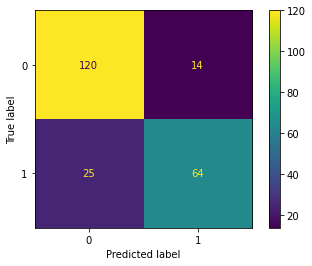

In [163]:
plot_confusion_matrix(final_model, X_test, y_test);

In [164]:
y_hat = final_model.predict(X_test)

In [165]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.83. 

Our final model's recall on the test set is 0.72 

Our final model's precision on the test set is 0.82 

Our final model's f1-score on the test is 0.77.



## Exercise: Your Turn!

Use SMOTE and an estimator (model) of your choice in a pipeline to model the exoplanets' method of discovery ("method"). You can build a model one feature at a time or just throw them all in from the beginning. Consider using the LabelEncoder (from sklearn.preprocessing) to code up the target. You'll also need to make a choice about how to handle the null values.

In [ ]:
exos = sns.load_dataset('planets')

In [ ]:
### Your work here






